# Code

## Packages

In [449]:
import argparse
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [450]:
import easydict
 
args = easydict.EasyDict({
    "total_pop_num": 100000,  #total_population number
    "epi_length": 100000,  # episode length
    "a": 0.035,  # infection probability
    "b": 10,  # frequency of contact
    "delay_period": 3,  # period of infected to confirmed
    "remove_period": 1,  # period of confirmed to removed
    "bounded": True,  # bounded rationality or not
    "g_init_infected_num" : 1
    # Parameters related with groups
})


## Model

In [451]:
class corona_world(object):
    def __init__(self, args):
        # Parameters
        self.total_pop_num = args.total_pop_num
        self.epi_length = args.epi_length
        self.a = args.a
        
        self.b = args.b

        self.delay_period = args.delay_period
        self.remove_period = args.remove_period
        self.bounded = args.bounded
        self.g_init_infected_num = args.g_init_infected_num
        # Variables changed by time 
        self.g_pop = np.zeros([self.epi_length + 1, 4])  # [time, type(S, I, C, R)]
        self.g_pop_change = np.zeros([self.epi_length + 1, 4]) # daily change, [time, type(S, I, C, R)]
        
    def initialize_world(self):
        total_g_pop_num = self.total_pop_num 
        infected_g_pop_num = self.g_init_infected_num
        self.g_pop[0, 0] = (total_g_pop_num - infected_g_pop_num) / total_g_pop_num
        self.g_pop[0, 1] = infected_g_pop_num / total_g_pop_num

    def step(self, time):
        if time <1000 :
            beta =  self.a * self.b
        else:
            beta = 1.1 *self.a * self.b

        
        # 당일 susceptible의 변화 / 당일의 activity에 따라 susceptible에서 infected로 가는 거 정의
        g_ds = - beta * self.g_pop[time-1,  1] * self.g_pop[time-1, 0] 
        
        # 당일 infected의 변화 / -g_ds만큼 더해지고 confirm되는 infected가 빠짐
        g_today_confirmed = 1 / self.delay_period * self.g_pop[time-1,  1]         
        g_di = - g_ds - g_today_confirmed
        
        # 당일 confirmed의 변화 / delay_period전 infected가 더해지고 전날 confirmed가 빠짐
        g_today_removed = 1 / self.remove_period * self.g_pop[time-1,  2]
        g_dc = g_today_confirmed - g_today_removed
        
        # 당일 removed의 변화 / 전날 confirmed가 더해짐
        g_dr = g_today_removed
        
        # g_pop의 변화
        self.g_pop[time,  0] = self.g_pop[time-1,  0] + g_ds
        self.g_pop[time,  1] = self.g_pop[time-1,  1] + g_di
        self.g_pop[time,  2] = self.g_pop[time-1,  2] + g_dc
        self.g_pop[time,  3] = self.g_pop[time-1,  3] + g_dr
        
        self.g_pop_change[time,  0] = g_ds
        self.g_pop_change[time,  1] = g_di
        self.g_pop_change[time,  2] = g_dc
        self.g_pop_change[time,  3] = g_dr
        
        if time%1000==0:

            self.g_pop[time,  0]-=1/self.total_pop_num
            self.g_pop[time,  1]+=1/self.total_pop_num
            
    def run(self):
        self.initialize_world()
        
        for j in range(self.epi_length):
            time = j + 1
            self.step(time)
            

In [452]:
class junyoung_world(object):
    def __init__(self, args):
        # Parameters
        self.total_pop_num = args.total_pop_num
        self.epi_length = args.epi_length
        self.a = args.a
        self.b = args.b
        self.delay_period = args.delay_period
        self.remove_period = args.remove_period
        self.bounded = args.bounded
        self.g_init_infected_num = args.g_init_infected_num
        self.u_remove_period = 7
        # Variables changed by time 
        self.g_pop = np.zeros([self.epi_length + 1, 5])  # [time, type(S, I, C, R, U)]
        self.g_pop_change = np.zeros([self.epi_length + 1, 5]) # daily change, [time, type(S, I, C, R, U)]
        
    def initialize_world(self):
        total_g_pop_num = self.total_pop_num 
        infected_g_pop_num = self.g_init_infected_num
        self.g_pop[0, 0] = (total_g_pop_num - infected_g_pop_num) / total_g_pop_num
        self.g_pop[0, 1] = infected_g_pop_num / total_g_pop_num

    def step(self, time):
        beta =  self.a * self.b

            
        # 당일 susceptible의 변화 
        g_ds = - beta * (self.g_pop[time-1, 1] + self.g_pop[time-1, 4]) * self.g_pop[time-1, 0] 
        
        # 당일 infected의 변화 / -g_ds만큼 더해지고 confirm되는 infected가 빠짐
        g_today_confirmed = 1 / self.delay_period * self.g_pop[time-1,  1]         
        g_di = - g_ds  - g_today_confirmed
        
        # 당일 confirmed의 변화 / delay_period전 infected가 더해지고 전날 confirmed가 빠짐
        g_today_removed = 1 / self.remove_period * self.g_pop[time-1,  2]
        g_dc = g_today_confirmed - g_today_removed
        
        # 당일 unreported의 변화 / poisson distribution
        g_joyong_removed = 1 / self.u_remove_period * self.g_pop[time-1, 4] 
        g_du = - g_joyong_removed 
        
        # 당일 removed의 변화 / 전날 confirmed가 더해짐
        g_dr = g_today_removed +g_joyong_removed

        # g_pop의 변화
        self.g_pop[time,  0] = self.g_pop[time-1,  0] + g_ds
        self.g_pop[time,  1] = self.g_pop[time-1,  1] + g_di
        self.g_pop[time,  2] = self.g_pop[time-1,  2] + g_dc
        self.g_pop[time,  3] = self.g_pop[time-1,  3] + g_dr
        self.g_pop[time,  4] = self.g_pop[time-1,  4] + g_du
        
        if time%1000==0:

            self.g_pop[time,  0]-=1/self.total_pop_num
            self.g_pop[time,  4]+=1/self.total_pop_num

        #self.g_pop_change[time,  0] = g_ds
        #self.g_pop_change[time,  1] = g_di
        #self.g_pop_change[time,  2] = g_dc
        #self.g_pop_change[time,  3] = g_dr
        #self.g_pop_change[time,  4] = g_du
    
    def run(self):
        self.initialize_world()
        
        for j in range(self.epi_length):
            time = j + 1
            self.step(time)

In [453]:
25%21

4

## Run

In [454]:
x = corona_world(args)
x.run()

In [455]:
y = junyoung_world(args)
y.run()

In [456]:
y2 = junyoung_world(args)
y2.run()

In [457]:
np.set_printoptions(precision=8, linewidth=np.inf)

# Plot

In [458]:
def plot_g_pop(world, period=0):
    plt.figure(figsize=(10, 7))
    
    if period == 0:
        plt.plot(world.g_pop[:,  0], label='Susceptible')
        plt.plot(world.g_pop[:,  1], label='Infected')
        plt.plot(world.g_pop[:,  2], label='Confirmed')
        plt.plot(world.g_pop[:,  3], label='Removed')
    else:
        plt.plot(world.g_pop[:period,  0], label='Susceptible')
        plt.plot(world.g_pop[:period,  1], label='Infected')
        plt.plot(world.g_pop[:period,  2], label='Confirmed')
        plt.plot(world.g_pop[:period,  3], label='Removed')
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Proportion', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    
def plot_g_pop_sicr(world, period=0, state=0):
    plt.figure(figsize=(10, 7))
    
    if period == 0:
        plt.plot(world.g_pop[:, state ], label='i')
    else:
        plt.plot(world.g_pop[:period,  state ], label='In')
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Proportion', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()

def plot_g(world, period=0):
    plt.figure(figsize=(10, 7))
    if period == 0:
        plt.plot(world.g_pop[:,  0] * world.total_pop_num, label='Susceptible')
        plt.plot(world.g_pop[:,  1]* world.total_pop_num, label='Infected')
        plt.plot(world.g_pop[:,  2]* world.total_pop_num, label='Confirmed')
        plt.plot(world.g_pop[:,  3]* world.total_pop_num, label='Removed')
    else:
        plt.plot(world.g_pop[:period,  0]* world.total_pop_num, label='Susceptible')
        plt.plot(world.g_pop[:period,  1]* world.total_pop_num, label='Infected')
        plt.plot(world.g_pop[:period,  2]* world.total_pop_num, label='Confirmed')
        plt.plot(world.g_pop[:period,  3]* world.total_pop_num, label='Removed')
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Proportion', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    
def plot_g_sicr(world, period=0, state=0):
    plt.figure(figsize=(10, 7))
    
    if period == 0:
        plt.plot(world.g_pop[:, state ]* world.total_pop_num, label='i')
    else:
        plt.plot(world.g_pop[:period,  state ]* world.total_pop_num, label='Infected')
#     plt.ylim([0, 1])
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Total number', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()

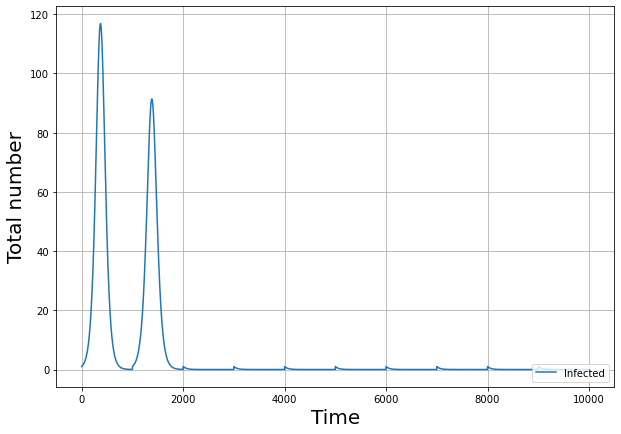

In [459]:
plot_g_sicr(x, 10000,1
          )

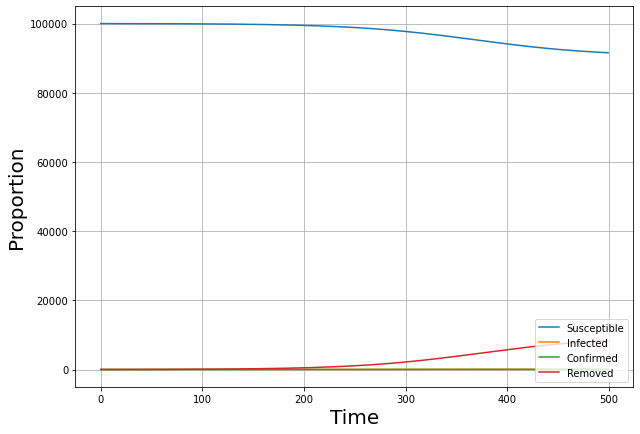

In [460]:
plot_g(y, 500)

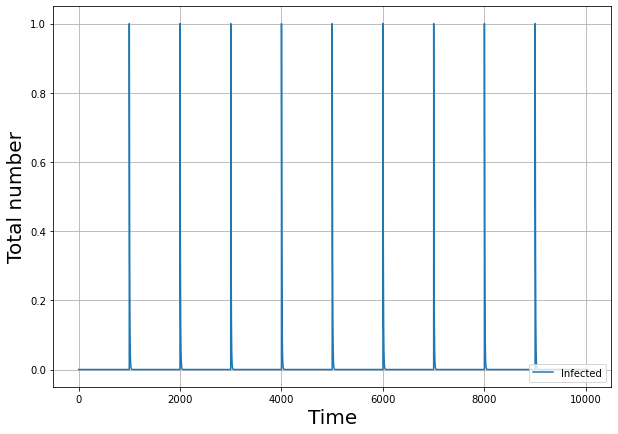

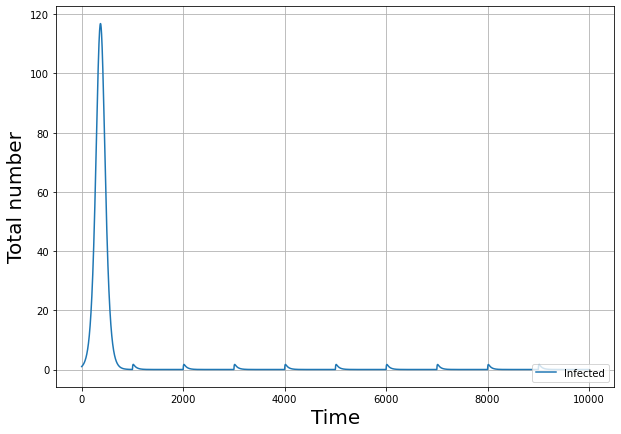

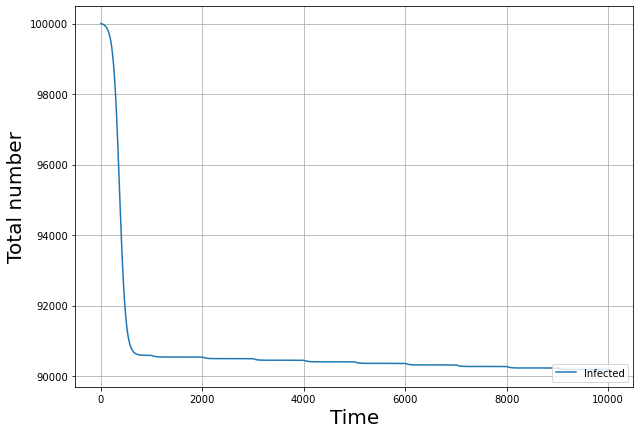

In [461]:
plot_g_sicr(y,10000,4)
plot_g_sicr(y,10000,1)
plot_g_sicr(y,10000,0)

In [462]:
print(x.g_pop[1000][3]-x.g_pop[10000][3])
print(x.g_pop[1000])


-0.08105450384876718
[9.05853088e-01 1.01555390e-05 5.10587974e-08 9.41367049e-02]
